# Load data

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from scipy.stats import uniform
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
import scipy
from catboost import CatBoostClassifier

In [18]:
# loading train data
train = pd.read_csv('/content/drive/MyDrive/train.csv')
# loading test data
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [19]:
Y = train['ACTION']
X = train[train.columns.difference(['ACTION'])]

In [20]:
X_test=test.drop(columns=['id'],axis=1)
X_test.shape

(58921, 9)

In [21]:
# loading train/test one_hot encoded data
f = open('/content/drive/MyDrive/1_hot_enc.pckl','rb')
X_train_ohe,X_test_ohe = pickle.load(f)
f.close()

In [22]:
def generating_samples(input_data, target_data):

    '''In this function, we will write code for generating samples with replacement of size 15k '''

    rows = np.random.choice(len(input_data), size=15000, replace=True)
    x = input_data.iloc[rows]
    y = target_data.iloc[rows]

    return x,y

In [93]:
class Classifier(object):
    '''class that trains & predict sklearn classifiers '''
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
    
    def feature_names(self):
        # for XGBoost classifier only
        return self.clf.get_booster().feature_names

In [103]:
class StackingClassifier(object):

    '''Custom stacking-classifier  '''

    def __init__(self, models, params):
        self.models = models
        self.params = params
    
    def train(self, X, Y, test, k):
        # splitting data into D1,D2 (50-50)
        X_D1, X_D2, Y_D1, Y_D2 = train_test_split(X, Y, test_size=0.5, stratify=Y, random_state=42)

        D2_pred = {}
        test_pred = {}

        for i in range(k):
            model = self.models[i % len(self.models)]
            param = self.params[i % len(self.params)]

            print(" training classifier "+str(i+1))
            
            # sampling data
            x1,y1 = generating_samples(X_D1,Y_D1)

            base_model = Classifier(model, params=param)          # training on sample data
            base_model.train(x1,y1)

            D2_pred[i] = base_model.predict(X_D2)   # base_model prediction on D2 data

            # base model prediction on test data
            if model==xgb.XGBClassifier:
                t = test[base_model.feature_names()]
                test_pred[i] = base_model.predict(t)
            else:
                test_pred[i] = base_model.predict(test)
        
        # storing k predictions in a dataframe
        train_data = pd.DataFrame(D2_pred)
        test_data = pd.DataFrame(test_pred)

        # training meta classifier
        lr = LogisticRegression(random_state=0,class_weight='auto')
        parameter = {'C':[10**i for i in range(-5,5)]}

        clf = GridSearchCV(lr, parameter, scoring='roc_auc',return_train_score=True, n_jobs=-1)   #hyperparameter tuning using gridsearch
        grid_result = clf.fit(train_data,Y_D2)

        print("Best auc: %f using %s" % (grid_result.best_score_, grid_result.best_params_))  #printing best auc score for best alpha
        c = grid_result.best_params_['C']

        meta = LogisticRegression(random_state=0,class_weight='auto',C=c)
        meta.fit(train_data,Y_D2)

        # final prediction on test data
        predictions = meta.predict_proba(test_data)[:,1]

        return meta,predictions    # returning final classifier and predictions

In [42]:
features = list(range(X.shape[1]))
print(features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [104]:
# list of models and there parameters

models = [CatBoostClassifier,xgb.XGBClassifier,RandomForestClassifier,LogisticRegression]

LR_param = {'C':1,
            'max_iter':1000,
            'class_weight':'balanced'}

RF_param = {'max_depth': 25,
            'max_features': 3,
            'min_samples_split': 3,
            'n_estimators': 437}


XGB_param = {'colsample_bytree': 0.3732907507832548,
            'learning_rate': 0.2620452218743664,
            'max_depth': 10,
            'min_child_weight': 1,
            'n_estimators': 309,
            'subsample': 0.9755215050028858}

CAT_param = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features':features,
          'verbose':False,
          'early_stopping_rounds': 200}

params = [CAT_param,XGB_param,RF_param,LR_param]

In [105]:
stc = StackingClassifier(models,params)

In [106]:
# checking score for different no of base_models
for k in range(2,12):
    print("\n no. of base_learners = ",k)
    meta,predictions = stc.train(X, Y, X_test,k=k)
    print("=================================")
    print("=================================")


 no. of base_learners =  2
 training classifier 1
 training classifier 2
Best auc: 0.848565 using {'C': 0.01}

 no. of base_learners =  3
 training classifier 1
 training classifier 2
 training classifier 3
Best auc: 0.856634 using {'C': 10000}

 no. of base_learners =  4
 training classifier 1
 training classifier 2
 training classifier 3
 training classifier 4
Best auc: 0.856930 using {'C': 10}

 no. of base_learners =  5
 training classifier 1
 training classifier 2
 training classifier 3
 training classifier 4
 training classifier 5
Best auc: 0.863643 using {'C': 1}

 no. of base_learners =  6
 training classifier 1
 training classifier 2
 training classifier 3
 training classifier 4
 training classifier 5
 training classifier 6
Best auc: 0.864614 using {'C': 0.1}

 no. of base_learners =  7
 training classifier 1
 training classifier 2
 training classifier 3
 training classifier 4
 training classifier 5
 training classifier 6
 training classifier 7
Best auc: 0.864899 using {'C': 

In [ ]:
# meta,predictions = stc.train(X, Y, X_test,k=10)
# data = {'ID':test["id"], 
#         'Action':predictions}
# res = pd.DataFrame(data)
# res.to_csv("stacking_classifier.csv", index = False)

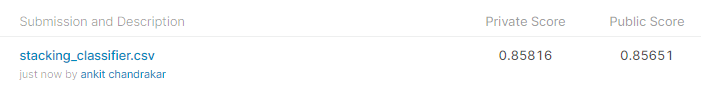

# Conclusion

* Got the best private_score of 0.85 with 10 base_models.
* Not that satisfactory result as compared to the single CatBoostClassifier(private_score = 0.908)